# Movie Recommendation Pipeline with Diversification

This notebook serves as a simple demo for the pass Culture recommender pipeline. The original pipeline is described in the figure 1: 
![alt text](images/pipeline_diagram.png "Figure 1: pass Culture recommender system pipeline")

This notebook only replicates the Two tower retreival model, the semantic embeddings with all-mini-L6-v2 and the DPP filter. The main goal of this notebook is to:
- serve as a simple demo for our paper
- Give practioners a ready-to-use notebook to test DPP architecture in recommenders systems
- Show the effect of DPP filtering on diversity of recommendations

## Dataset:
The original data at pass culture contains items and the description of the items (for example: a movie and the plot of the movie, or a book and the description of the book). These descriptions are used to generate semantic embedding for the items. To mimic the pass culture, we use the movieLens dataset in this notebook. To get "item descriptions", we use [`vishnupriyavr/wiki-movie-plots-with-summaries`]( https://huggingface.co/datasets/vishnupriyavr/wiki-movie-plots-with-summaries) dataset to get movies plots which will be later embedded by all-mini-l6-v2. 923 movies are kept after filtering.

## Steps covered in this notebook
#### 1. Preparation of data and Two Tower model:
- Load and preprocess movieLens movie and ratings data only keeping those that have a plot summary.
- Compute semantic embeddings of movies plots
- Train a two-tower retrieval model following the tensorflow recommenders [tutoriel](https://www.tensorflow.org/recommenders/examples/basic_retrieval)

#### 2. Study DPP module
- Create the DPP module through `DiversificationPipeline` class
- Benchmark retrieval vs retrieval + DPP:
    - For one user, retrieve 100 movies with the Two Tower retrieval model 
    - Get top 10 recommendations with highest cosine similarity with the user
    - Sample 10 diversified movies from the 100 retrieved recommendations.
    -  plot the two sets of recommendations in a 2D plot by projecting the item embeddings with a PCA.
    - Compute volume metric : The volume of the recommended items is a measure of diversification. It is computed as the square root of the determinant of the matrix containing semantic embeddings of the items. The bigger the volume, the more diversified the set of items is.


In [9]:
## imports
from typing import Dict, Text, List

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

from sentence_transformers import SentenceTransformer

from dppy.finite_dpps import FiniteDPP

import lancedb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

## Step 1: load and preprocess movieLens data 
- only keep movies which have a plot summary
- create a train dataset with 50k samples and a test set with about 16k samples.

In [6]:

# Load the movie plots dataset from HuggingFace 
df_movies_plots = pd.read_csv(
    "hf://datasets/vishnupriyavr/wiki-movie-plots-with-summaries/wiki_movie_plots_deduped_with_summaries.csv"
)[['Title', 'PlotSummary']]

df_movies_plots.drop_duplicates(subset=['Title'], keep='last', inplace=True)

## Load movies and ratings dataset from TFRS
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")


## Filter movies and ratings dataset to keep those with plots
ratings_list = list(ratings)  # Will work for 100k dataset
ratings_dicts = [
    {
        "user_id": x["user_id"].numpy().decode("utf-8"),
        "movie_title": x["movie_title"].numpy().decode("utf-8"),
    }
    for x in ratings_list
]
ratings_df = pd.DataFrame(ratings_dicts)
ratings_df.movie_title = ratings_df.movie_title.map(lambda x: x.split('(')[0].strip())
ratings_df = pd.merge(ratings_df, df_movies_plots, left_on='movie_title', right_on='Title', how='inner')[['user_id', 'movie_title']]
ratings_ds = tf.data.Dataset.from_tensor_slices(dict(ratings_df))

## Filter movies dataset
movies_list = list(movies)  
movies_dicts = [
    {
        "movie_title": x["movie_title"].numpy().decode("utf-8"),
    }
    for x in movies_list
]
movies_df = pd.DataFrame(movies_dicts)
movies_df.movie_title = movies_df.movie_title.map(lambda x: x.split('(')[0].strip())
movies_df = pd.merge(movies_df, df_movies_plots, left_on='movie_title', right_on='Title', how='inner')[['movie_title']]
movies_ds = tf.data.Dataset.from_tensor_slices(dict(movies_df))


# Prepare the ratings dataset for training
ratings_ds = ratings_ds.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
})
movies_ds = movies_ds.map(lambda x: x["movie_title"])


# Shuffle and split the data
tf.random.set_seed(42)
shuffled = ratings_ds.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(50_000) ## After filtering rating_ds has 67,921 rows
test = shuffled.skip(50_000).take(20_000)

# Prepare unique user and movie vocabularies
movie_titles = movies_ds.batch(1_000)
user_ids = ratings_ds.batch(1_000_000).map(lambda x: x["user_id"])
unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

# Filter the df_movies_plots datafrale to keep only movies that exist in movielens
df_movies_plots = df_movies_plots[df_movies_plots.Title.isin([str(movie_name.decode("utf-8")) for movie_name in unique_movie_titles])]


## Step 2: compute semantic embeddings of movies plot summaries


In [29]:
## Add the semantic embeddings to the df_movies_plots 

# Load the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings
df_movies_plots['plot_semantic_embedding'] = df_movies_plots['PlotSummary'].apply(lambda x: model.encode(x, convert_to_numpy=True))


## Step 3: Build and train the two tower model

In [4]:
## Define the Two Tower model 
embedding_dimension = 32

user_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  # We add an additional embedding to account for unknown tokens.
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

movie_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_movie_titles, mask_token=None),
  tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])

metrics = tfrs.metrics.FactorizedTopK(
  candidates=movies_ds.batch(128).map(movie_model)
)

task = tfrs.tasks.Retrieval(
  metrics=metrics
)

class MovielensModel(tfrs.Model):
  def __init__(self, user_model, movie_model):
    super().__init__()
    self.movie_model: tf.keras.Model = movie_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model,
    # getting embeddings back.
    positive_movie_embeddings = self.movie_model(features["movie_title"])

    # The task computes the loss and the metrics.
    return self.task(user_embeddings, positive_movie_embeddings)

In [5]:
## Train the model
model = MovielensModel(user_model, movie_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

model.fit(cached_train, epochs=10)

model.evaluate(cached_test, return_dict=True)

Epoch 1/10
7/7 [==============================] - 5s 244ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0017 - factorized_top_k/top_5_categorical_accuracy: 0.0128 - factorized_top_k/top_10_categorical_accuracy: 0.0288 - factorized_top_k/top_50_categorical_accuracy: 0.1266 - factorized_top_k/top_100_categorical_accuracy: 0.2195 - loss: 56640.2168 - regularization_loss: 0.0000e+00 - total_loss: 56640.2168
Epoch 2/10
7/7 [==============================] - 2s 249ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0046 - factorized_top_k/top_5_categorical_accuracy: 0.0302 - factorized_top_k/top_10_categorical_accuracy: 0.0607 - factorized_top_k/top_50_categorical_accuracy: 0.2416 - factorized_top_k/top_100_categorical_accuracy: 0.3898 - loss: 55053.2190 - regularization_loss: 0.0000e+00 - total_loss: 55053.2190
Epoch 3/10
7/7 [==============================] - 2s 229ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0056 - factorized_top_k/top_5_categorical_accuracy: 0.0

{'factorized_top_k/top_1_categorical_accuracy': 0.000279002299066633,
 'factorized_top_k/top_5_categorical_accuracy': 0.003961832262575626,
 'factorized_top_k/top_10_categorical_accuracy': 0.011829696595668793,
 'factorized_top_k/top_50_categorical_accuracy': 0.12008258700370789,
 'factorized_top_k/top_100_categorical_accuracy': 0.25846773386001587,
 'loss': 11071.4052734375,
 'regularization_loss': 0,
 'total_loss': 11071.4052734375}

## Step 3: Build a vector database containing the movies two-tower embeddings 
The vector database is built with lancedb and servers to retrieve closest movies to a user given the user two tower embedding.

In [12]:
# Create movies_docs
movies_list = movie_model.layers[0].get_vocabulary()
movies_weights = movie_model.layers[1].get_weights()[0].astype(np.float32)
movie_data = [
    {"movie_name": name, "vector": embedding}
    for name, embedding in zip(movies_list, movies_weights)
]
# Create or open a local LanceDB
db = lancedb.connect("./tmp/lancedb")

# Create a table from the movie data
movies_table = db.create_table("movies", data=movie_data, mode="overwrite")


## Step 4: build DPP module

In [10]:
class DiversificationPipeline:
    def __init__(self, item_semantic_embeddings: List, ids: List, scores: List) -> None:
        self.item_semantic_embeddings = np.array(
            item_semantic_embeddings, dtype=np.float64
        )
        self.item_ids = ids
        self.scores = np.array(scores, dtype=np.float64) ## scores are relevance qi score from TT

    @staticmethod
    def _get_dpp_samples(vectors: np.ndarray, K_DPP: int) -> List:
        diversification_matrix = vectors.dot(vectors.T)
        dpp_model = FiniteDPP("likelihood", **{"L": diversification_matrix})
        return dpp_model.sample_exact_k_dpp(size=K_DPP)

    def get_sampled_ids(self, K_DPP: int, use_qi: bool) -> List:
        # Calculate weighted embeddings and normalize in a single step
        weighted_embeddings = (
            self.scores[:, np.newaxis] * self.item_semantic_embeddings
            if use_qi
            else self.item_semantic_embeddings
        )

        # Apply DPP sampling
        sampled_indices = self._get_dpp_samples(
            vectors=weighted_embeddings, K_DPP=K_DPP
        )

        return [self.item_ids[i] for i in sampled_indices]
    
 

## Step 5: test top and diversified retrievals for one user

In [37]:

def retrieval(k, user_id, user_embedding_dict, use_qi=True):
    user_vector = user_embedding_dict[user_id]
    # Search for top 100 most similar movies using cosine similarity
    # the movies dataset contains 923 so we set the retrieval to 100 so its an upper bound for all results
    results = movies_table.search(user_vector).metric("cosine").limit(100).to_pandas()
    results["cosine_similarity"] = 1 - results["_distance"]  
    ## add semantic embeddings to results df
    results = pd.merge(results, df_movies_plots, left_on="movie_name", right_on="Title", how='inner')
    
    ## Get top_k recommendations
    results_top_k = results.sort_values(by='cosine_similarity', ascending=False).head(k)['movie_name'].to_list()
    
    ## Get k diversified recommendations
    retrieved_movies = results.to_dict(orient='records')
    results_k_diversified = DiversificationPipeline(
                                            item_semantic_embeddings=[
                                                item["plot_semantic_embedding"] for item in retrieved_movies
                                            ],
                                            ids=[item["movie_name"] for item in retrieved_movies],
                                            scores=[float(item["cosine_similarity"]) for item in retrieved_movies],
                                        ).get_sampled_ids(K_DPP=k, use_qi=use_qi)
    return results_top_k, results_k_diversified
                                            


In [38]:
users_list = user_model.layers[0].get_vocabulary()
users_weights = user_model.layers[1].get_weights()[0].astype(np.float32)
user_embedding_dict = {x: y for x, y in zip(users_list, users_weights)}
user_id = users_list[100] # the 101th user_id 

results_top_k, results_k_diversified =  retrieval(10, user_id, user_embedding_dict, use_qi=True)
results_top_k, results_k_diversified

## Step 6: Apply a PCA to visualize recommendations in 2D

In [43]:
# Apply a PCA on all semantic embeddings
movies_names_list = df_movies_plots['Title'].to_list()
mobies_plots_list = df_movies_plots['plot_semantic_embedding'].to_list()
X = np.array(mobies_plots_list)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

In [60]:
def plot_two_sets_of_recos(results_top_k,results_k_diversified, X_2d):
    plt.figure(figsize=(8, 6))

    # Plot top_k recommendations
    top_k_movies_indices = [movies_names_list.index(movie_name) for movie_name in results_top_k]
    plt.scatter([X_2d[i, 0] for i in top_k_movies_indices],
                [X_2d[i, 1] for i in top_k_movies_indices], 
                color='red', label="top k recommendations")

    # Plot top_k recommendations
    diversified_k_movies_indices = [movies_names_list.index(movie_name) for movie_name in results_k_diversified]
    plt.scatter([X_2d[i, 0] for i in diversified_k_movies_indices],
                [X_2d[i, 1] for i in diversified_k_movies_indices], 
                color='blue', label="diversified k recommendations")


    plt.title("Movie Embeddings (PCA 2D)")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.grid(True)
    plt.show()


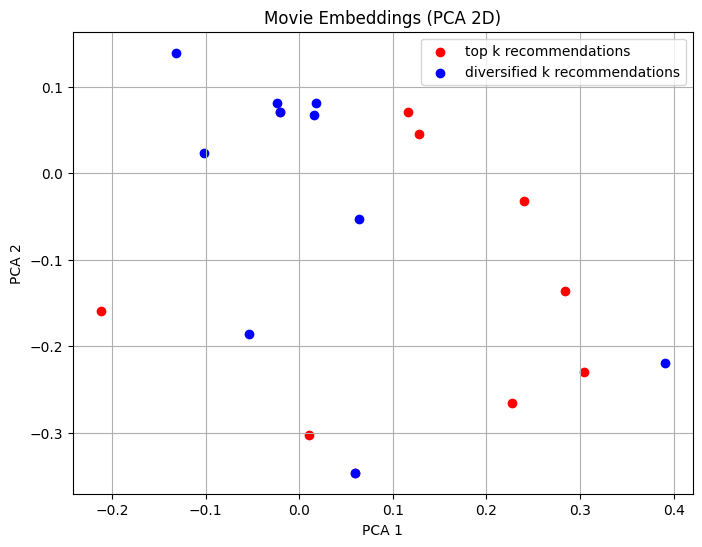

In [61]:
plot_two_sets_of_recos(results_top_k,results_k_diversified, X_2d)

In [59]:
X_diversified = np.stack(df_movies_plots[df_movies_plots.Title.isin(results_k_diversified)]['plot_semantic_embedding'].to_numpy())
volume_diversified = np.linalg.det(X_diversified@X_diversified.T)

X_top_k = np.stack(df_movies_plots[df_movies_plots.Title.isin(results_top_k)]['plot_semantic_embedding'].to_numpy())
volume_top_k = np.linalg.det(X_top_k@X_top_k.T)

volume_diversified, volume_top_k
print(f"The diversified recommendations have a volume {volume_diversified/volume_top_k} bigger than non diversified recos")

The diversified recommendations have a volume 1.1379022598266602 bigger than non diversified recos


## Step 7: try without quality relevance scores:

In [62]:
users_list = user_model.layers[0].get_vocabulary()
users_weights = user_model.layers[1].get_weights()[0].astype(np.float32)
user_embedding_dict = {x: y for x, y in zip(users_list, users_weights)}
user_id = users_list[100] # the 101th user_id 

results_top_k, results_k_diversified_no_qi =  retrieval(10, user_id, user_embedding_dict, use_qi=False)
results_top_k, results_k_diversified_no_qi

(['Red Firecracker, Green Firecracker',
  'Gaslight',
  'Aparajito',
  'Roman Holiday',
  'Picture Bride',
  'Picnic',
  'Death in Brunswick',
  'Ran',
  'To Be or Not to Be',
  'Golden Earrings'],
 ['Spellbound',
  'Bringing Up Baby',
  'Picnic',
  'Roman Holiday',
  'Withnail and I',
  'Matilda',
  "Breakfast at Tiffany's",
  'Jefferson in Paris',
  'Death in Brunswick',
  'Pather Panchali'])

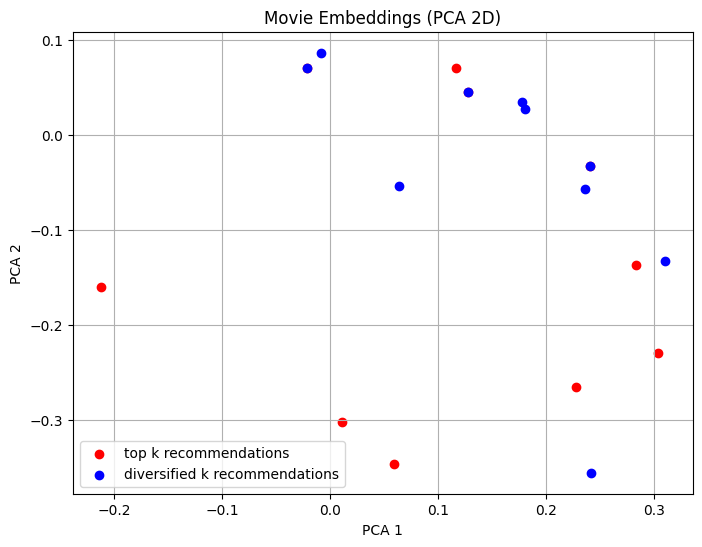

In [63]:
plot_two_sets_of_recos(results_top_k,results_k_diversified_no_qi, X_2d)

In [64]:
X_diversified_no_qi = np.stack(df_movies_plots[df_movies_plots.Title.isin(results_k_diversified_no_qi)]['plot_semantic_embedding'].to_numpy())
volume_diversified_no_qi = np.linalg.det(X_diversified_no_qi@X_diversified_no_qi.T)

X_top_k = np.stack(df_movies_plots[df_movies_plots.Title.isin(results_top_k)]['plot_semantic_embedding'].to_numpy())
volume_top_k = np.linalg.det(X_top_k@X_top_k.T)

volume_diversified_no_qi, volume_top_k
print(f"The diversified_no_qi recommendations have a volume {volume_diversified_no_qi/volume_top_k} bigger than non diversified_no_qi recos")

The diversified_no_qi recommendations have a volume 1.2565752267837524 bigger than non diversified_no_qi recos
